In [63]:
import musx
from musx import Interval
from musx.midi.gm import Marimba, PizzicatoStrings, ElectricSnare
from musx.ran import beta, between, brown, odds, uniran
SNARE = ElectricSnare + 1


def gamecube(q, envelope: list, mode: str, num_notes: int, min_key: int, max_key: int, rhy: float, chord_intervals=[], chord_chance=0.2):
    play_strings = True
    for i in range(num_notes):
        x = musx.rescale(i, 0, num_notes, 0, 1)  # get position in composition
        # get mapped x value from envelope
        y = musx.interp(x, envelope, mode=mode)

        # Take y and convert to keynum based on arguments
        min_env_val, max_env_val = min(envelope), max(envelope)
        key = musx.rescale(y, min_env_val, max_env_val, min_key, max_key)

        # Get note
        dur = 0.25
        amp = 0.8
        root_pitch = musx.Pitch.from_keynum(int(key))

        # Add marimba
        marimba = musx.Note(time=q.now, duration=dur,
                            pitch=root_pitch.keynum(), amplitude=amp, instrument=0)
        q.add(marimba)

        # Add strings, if necessary
        if play_strings:
            if odds(chord_chance):
                pitches = [root_pitch] + \
                    [i.transpose(root_pitch) for i in chord_intervals]
                for p in pitches:
                    pizz = musx.Note(time=q.now, duration=dur,
                                     pitch=p.keynum(), amplitude=amp, instrument=1)
                    q.add(pizz)
            else:
                q.add(musx.Note(time=q.now, duration=dur, pitch=root_pitch.keynum(
                ) + between(-5, 5), amplitude=amp, instrument=1))
        play_strings = not play_strings
        yield rhy

    # Pause
    yield rhy * 4

    # Add snare roll
    q.add(musx.Note(time=q.now, duration=dur,
          pitch=SNARE, amplitude=amp/4, instrument=9))
    yield rhy/2
    q.add(musx.Note(time=q.now, duration=dur,
          pitch=SNARE, amplitude=amp/2, instrument=9))
    yield rhy/2

    # Play hit at the end
    pitches = [musx.Pitch.from_keynum(between(min_key, max_key))] + \
        [i.transpose(root_pitch) for i in chord_intervals]
    for p in pitches:
        pizz = musx.Note(time=q.now, duration=dur,
                         pitch=p.keynum(), amplitude=amp, instrument=1)
        q.add(pizz)
    q.add(musx.Note(time=q.now, duration=dur,
          pitch=SNARE, amplitude=amp, instrument=9))


In [64]:
sequence = musx.Seq()
envelope_score = musx.Score(sequence)
ENV_LENGTH = 20
envelope = [round(uniran(), 2) for _ in range(ENV_LENGTH)]
MODE = 'cos'
print(envelope)

[0.4, 0.15, 0.53, 0.88, 0.68, 0.92, 0.35, 0.74, 0.82, 0.71, 0.99, 0.03, 1.0, 0.54, 0.62, 0.4, 0.27, 0.67, 0.11, 0.05]


In [65]:
import matplotlib.pyplot as plt

def plot(data):
    plt.plot(data)
    plt.show()

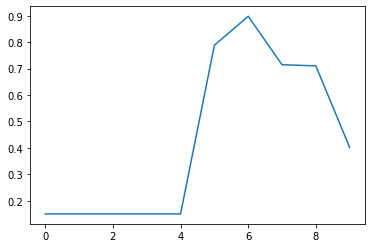

In [66]:
data = []
for x in musx.frange(0, 1, .1):
    y = musx.interp(x, envelope, mode=MODE)
    data.append(y)
plot(data)

In [67]:
NUM_NOTES = 70
MIN_KEY, MAX_KEY = 40, 100
rhy = 0.12
envelope_score.compose([0, gamecube(envelope_score, envelope, MODE, NUM_NOTES, MIN_KEY, MAX_KEY, rhy, [
    Interval('M3'), Interval('P5'), Interval('M7')
])])
track0 = musx.MidiFile.metatrack(ins={0: Marimba, 1: PizzicatoStrings})
env_file = musx.MidiFile("gamecube.mid", [track0, sequence]).write()
print('OK!')

OK!
